In [36]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
from src.schedulers.linear import LinearNoiseScheduler

class NoiseSchedulerVisualizer:
    """
    Visualization tool for noise schedulers to demonstrate the forward and reverse diffusion processes.
    """
    def __init__(self, scheduler, device=None, image_size=(3, 1024, 1024)):
        """
        Initialize visualizer with a scheduler and default image size.

        Args:
            scheduler: Noise scheduler instance
            device: torch.device to use
            image_size (tuple): Size of images to use (C, H, W)
        """
        self.scheduler = scheduler
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.scheduler.to(self.device)
        self.image_size = image_size

        # Set up image transforms
        self.transform = T.Compose([
            T.Resize((image_size[1], image_size[2])),
            T.ToTensor(),
            T.Lambda(lambda x: (x * 2) - 1)  # Scale to [-1, 1]
        ])

    def load_image(self, image_path):
        """Load and preprocess an image."""
        image = Image.open(image_path).convert('RGB')
        return self.transform(image).unsqueeze(0).to(self.device)

    def tensor_to_image(self, tensor):
        """Convert tensor from [-1,1] to valid image range [0,1]."""
        return torch.clamp((tensor + 1) / 2, 0, 1)

    def visualize_forward_process(self, image, num_steps=10):
        """
        Visualize the forward diffusion process.

        Args:
            image (torch.Tensor): Input image tensor
            num_steps (int): Number of diffusion steps to visualize
        """
        timesteps = torch.linspace(0, self.scheduler.num_timesteps-1, num_steps).long()

        # Generate noise steps
        noisy_images = []
        fig, axes = plt.subplots(1, num_steps, figsize=(20, 4))
        fig.suptitle('Forward Diffusion Process', fontsize=16)

        for idx, t in enumerate(timesteps):
            noise = torch.randn_like(image)
            noisy = self.scheduler.add_noise(image, noise, t.unsqueeze(0).to(self.device))
            noisy_image = self.tensor_to_image(noisy)

            # Plot directly to avoid grid
            img_np = noisy_image.squeeze().permute(1, 2, 0).cpu().numpy()
            axes[idx].imshow(img_np)
            axes[idx].axis('off')
            axes[idx].set_title(f't={t.item()}')

        plt.tight_layout()
        plt.show()

    def plot_noise_schedule(self):
        """Visualize the noise schedule parameters."""
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle('Noise Schedule Parameters', fontsize=16)

        # Plot betas
        ax1.plot(self.scheduler.betas.cpu().numpy())
        ax1.set_title('Beta Schedule')
        ax1.set_xlabel('Timestep')
        ax1.set_ylabel('Beta')

        # Plot alphas
        ax2.plot(self.scheduler.alphas.cpu().numpy())
        ax2.set_title('Alpha Values')
        ax2.set_xlabel('Timestep')
        ax2.set_ylabel('Alpha')

        # Plot cumulative alphas
        ax3.plot(self.scheduler.alpha_cum_prod.cpu().numpy())
        ax3.set_title('Cumulative Alpha')
        ax3.set_xlabel('Timestep')
        ax3.set_ylabel('Alpha Cumulative Product')

        plt.tight_layout()
        plt.show()


def show_example(image_path=None):
    """
    Show example visualization with the noise scheduler.

    Args:
        image_path (str, optional): Path to test image
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create scheduler
    scheduler = LinearNoiseScheduler(
        num_timesteps=100,
        beta_start=1e-4,
        beta_end=0.16,
        device=device
    )

    # Create visualizer
    viz = NoiseSchedulerVisualizer(scheduler, device)

    # Show noise schedule
    print("Plotting noise schedule parameters...")
    viz.plot_noise_schedule()

    # Show forward process if image provided
    if image_path:
        print("Visualizing forward diffusion process...")
        image = viz.load_image(image_path)
        viz.visualize_forward_process(image, num_steps=10)





Using device: cuda
Plotting noise schedule parameters...


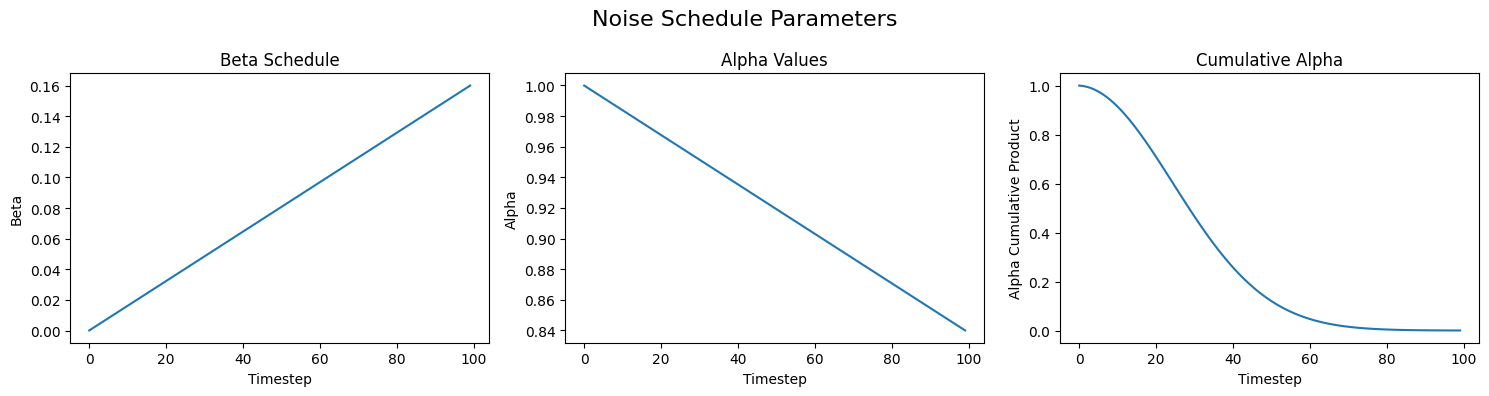

Visualizing forward diffusion process...


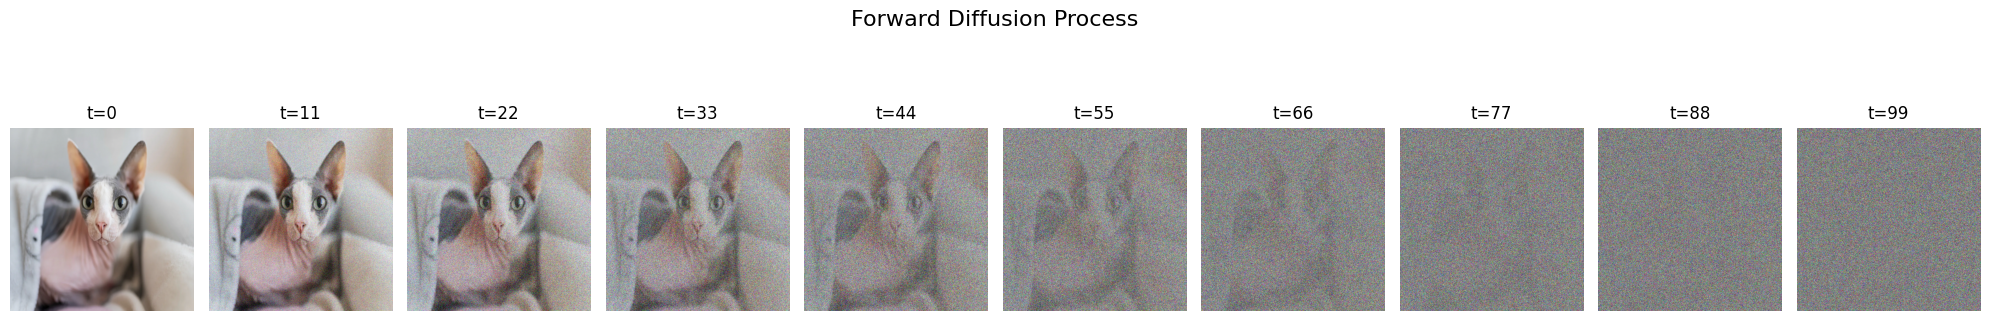

In [37]:
show_example('cat.jpg')